In [5]:
import ipynb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
from scipy import signal
# import neurokit2 as nk
import random
# %matplotlib inline 
import pyhrv
import ipynb

from ipynb.fs.full.ECG_features import get_ecgfeatures
from ipynb.fs.full.EDA import get_edaindex, get_edafeatures

In [6]:
class read_data_of_one_subject:
            """Read data from WESAD dataset"""
            def __init__(self, path, subject):
                self.keys = ['label', 'subject', 'signal']
                self.signal_keys = ['wrist', 'chest']
                self.chest_sensor_keys = ['ACC', 'ECG', 'EDA', 'EMG', 'Resp', 'Temp']
                self.wrist_sensor_keys = ['ACC', 'BVP', 'EDA', 'TEMP']
                #os.chdir(path)
                #os.chdir(subject)
                with open(path + subject +'/'+subject + '.pkl', 'rb') as file:
                    data = pickle.load(file, encoding='latin1')
                self.data = data

            def get_labels(self):
                return self.data[self.keys[0]]

            def get_wrist_data(self):
                """"""
                #label = self.data[self.keys[0]]
                assert subject == self.data[self.keys[1]]
                signal = self.data[self.keys[2]]
                wrist_data = signal[self.signal_keys[0]]
                #wrist_ACC = wrist_data[self.wrist_sensor_keys[0]]
                #wrist_ECG = wrist_data[self.wrist_sensor_keys[1]]
                return wrist_data

            def get_chest_data(self):
                """"""
                signal = self.data[self.keys[2]]
                chest_data = signal[self.signal_keys[1]]
                return chest_data

In [74]:
# Set up empty dataframes for the features
ecgfeatures = pd.DataFrame(None, columns= ['HR_mean', 'HR_min', 'HR_max', 'HR_std', 'SDNN', 'SDANN', 'RMSSD', 'SDSD','pNN50', 'pNN20', 
                                    'abs_power_VLF', 'abs_power_LF', 'abs_power_HF', 'tot_power', 'LF/HF', 
                                    'peak_vlf', 'peak_lf', 'peak_hf', 'norm_power_LF', 'norm_power_HF'])
edafeatures = None

fs = 700
y = []
data_set_path= "C:/Users/JackC/Documents/EPO4/WESAD/WESAD/" # Folder path
#data_set_path= "C:/Users/riche/Downloads/WESAD/WESAD/" # Folder path

for i in range(16): # 15 subject
    subject = 'S'+str(i+2) # Cycle through S2 to S17
    print(subject)
    if subject != 'S12': # Skip S12, because it does not exist
        # Object instantiation
        obj_data = {}

        # Accessing class attributes and method through objects
        obj_data[subject] = read_data_of_one_subject(data_set_path, subject)

        chest_data_dict = obj_data[subject].get_chest_data()
        chest_dict_length = {key: len(value) for key, value in chest_data_dict.items()}

        # Get labels
        labels = obj_data[subject].get_labels()

        for label in range(1,5): # for every state of stress
            
            baseline = np.asarray([idx for idx,val in enumerate(labels) if val == label])

            eda_base=chest_data_dict['EDA'][baseline,0] # Select the EDA data
            ecg_base=chest_data_dict['ECG'][baseline,0] # Select the ECG data
            resp_base=chest_data_dict['Resp'][baseline,0] # Select the respiration data

            tonic, phasic, start, end = get_edaindex(eda_base, fs)

            #Matching the index of the phasic to the other signals
            ecg = ecg_base[start: end]
            resp = resp_base[start: end]
            tonic = tonic[start: end]

            # Multiple (5) samples per signal
            # for j in range(5):

            #     # adding the labels to y
            #     if label==3 or label==4:
            #         y.append(1)
            #     else:
            #         y.append(label)

            #     # choosing a random begin point
            #     begin = random.randint(0, min(len(ecg),len(tonic),len(phasic))- 35000)

            #     # looking at a smaller section of the signal
            #     sample_ecg = ecg[begin: begin + 25 * fs]
            #     sample_tonic = tonic[begin: begin + 25 * fs]
            #     sample_phasic = phasic[begin: begin + 25 * fs]

            #     # getting the eda and ecg features
            #     index = subject + str(label) + str(j)
            #     edafeatures = get_edafeatures(index, edafeatures, phasic, tonic, fs)
            #     ecgfeatures = get_ecgfeatures(ecg, fs, ecgfeatures, index)

            # One sample per signal

            if label==3 or label==4:
                    y.append(1)
            else:
                y.append(label)

            index = subject + str(label) 
            edafeatures = get_edafeatures(index, edafeatures, phasic, tonic, fs)
            ecgfeatures = get_ecgfeatures(ecg, fs, ecgfeatures, index)


            # Plot a signal

            # t=np.arange(0,eda_base.size*(1/fs),(1/fs))
            # t=t[:eda_base.size]
            
            # plt.figure(figsize=(12,4))
            # plt.plot(t, eda_base)
            # plt.xlabel('$Time (s)$') 
            # plt.ylabel('$signal$')


S2
S3
S4
S5
S6
S7
S8
S9
S10
S11
S12
S13
S14
S15
S16
S17


In [135]:
# saving the feature data in csv files
edafeatures.to_csv("EDA_features.csv")
ecgfeatures.to_csv("ECG_features.csv")

features = pd.merge(ecgfeatures, edafeatures, left_index=True, right_index=True)
features.to_csv("out_features.csv")

In [9]:
# reading from csv file if necessary
# features = pd.read_csv('out_features.csv', index_col=0)

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import svm

In [133]:
total_features = pd.merge(ecgfeatures, edafeatures, left_index=True, right_index=True)
y_feat = y

# Performing PCA

ValueError: 'c' argument has 40 elements, which is inconsistent with 'x' and 'y' with size 60.

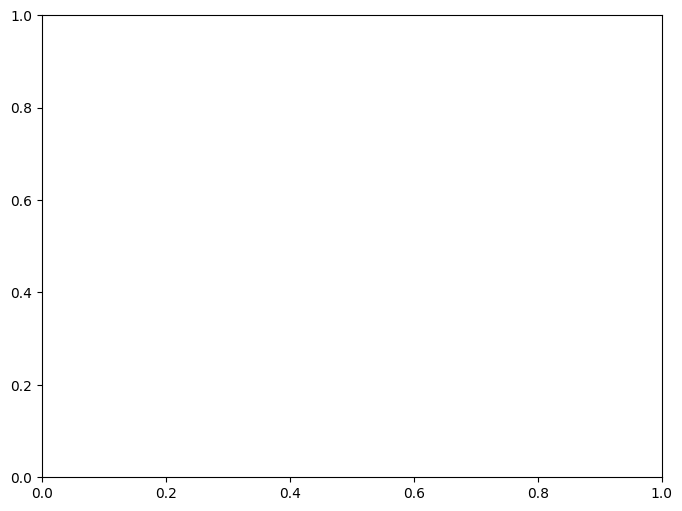

In [139]:
scaler = StandardScaler().fit(features)
X_train = scaler.transform(features)

pca = PCA(n_components=25)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
x_train = X_train_pca[:,0:3] # Three best features

plt.figure(figsize=(8,6))
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y)

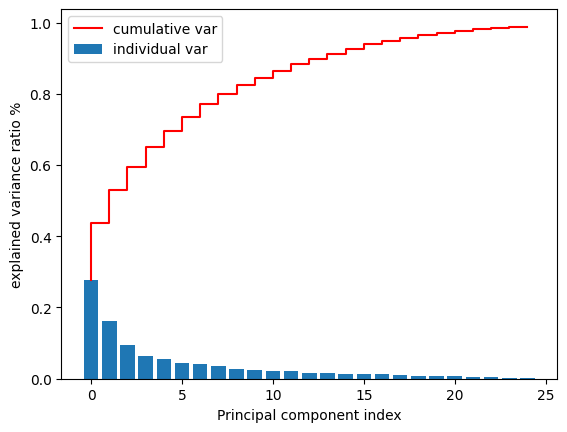

In [13]:
# perform pca on features
plt.bar(range(0,25), pca.explained_variance_ratio_, label="individual var");
plt.step(range(0,25), np.cumsum(pca.explained_variance_ratio_),'r', label="cumulative var");
plt.xlabel('Principal component index'); plt.ylabel('explained variance ratio %');
plt.legend()

In [14]:
# Splitting the data in train and test data
X_train, X_test, y_train, y_test = train_test_split(x_train, y, test_size=0.2, random_state=5)
# X_train, X_test, y_train, y_test = features[0:57], features[57:], y[0:57], y[57:]
# X_train, X_test, y_train, y_test = features[0:336], features[336:], y[0:336], y[336:]

# Scaling the data

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Logistic regression

In [15]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
Y_test_pred = logistic_model.predict(X_test)
log_score = logistic_model.score(X_test,y_test)

# SVM

In [16]:
from sklearn import datasets, svm
svm_model = svm.SVC()
svm_model.fit(X_train, y_train)
Y_test_pred = svm_model.predict(X_test)
svm_score = svm_model.score(X_test,y_test)

# Neural Networks

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

val_accuracies = []
for i in range(5): # run 5 times with 5 random states to determine model accuracy
    # Splitting the data in train and test data
    X_train, X_test, y_train, y_test = train_test_split(x_train, y, test_size=0.2, random_state= i + 1)

    # Scaling the data
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    ## Convert labels to categorical
    y_train_cat = to_categorical(y_train)
    y_test_cat = to_categorical(y_test)

    # Define the feedforward neural network
    neural_model = Sequential()
    neural_model.add(Dense(64, activation='relu', input_shape=(3,)))
    neural_model.add(Dense(64, activation='relu'))
    neural_model.add(Dense(64, activation='relu'))
    neural_model.add(Dense(64, activation = 'relu'))
    neural_model.add(Dropout(0.5))
    neural_model.add(Dense(3, activation='softmax'))

    # Compile the model
    optimizer = Adam(learning_rate=0.001)
    neural_model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    # Train the model
    # history = model.fit(X_train_pca, y_train, validation_data=(X_test_pca, y_test), epochs=45, batch_size=100, verbose=2)
    history = neural_model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat), epochs=45, batch_size=100, verbose=0)
    val_accuracy = history.history['val_accuracy'][-1]
    val_accuracies.append(val_accuracy) # accuracy score

print(val_accuracies)
avg_val_accuracy = sum(val_accuracies) / len(val_accuracies) # average of accurracy scores
print("Average Validation Accuracy:", avg_val_accuracy)

[0.9166666865348816, 0.8333333134651184, 0.8333333134651184, 0.8333333134651184, 0.9166666865348816]
Average Validation Accuracy: 0.8666666626930237


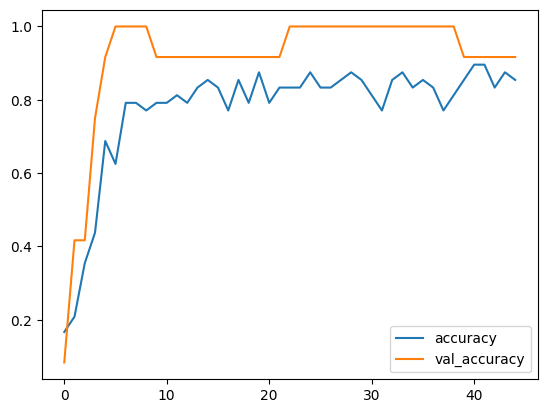

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])

# Random forest method

In [19]:
#from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

# define the model
randomf_model = RandomForestClassifier()

# fit/train the model on all features
randomf_model.fit(X_train, y_train)
Y_test_pred = randomf_model.predict(X_test)

#score
rf_score=randomf_model.score(X_test, y_test)

# get feature importance
importance = randomf_model.feature_importances_

#creat a dictionary with key=indices, and values=importance
important_features_dict = {}
for idx, val in enumerate(importance):
    important_features_dict[idx] = val
# sorting 
important_features_list = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)
# print indices of top 5 features
print(important_features_list[:5])
#plt.plot(importance)

[2, 1, 0]


# Scores

In [20]:
y_test_cat = to_categorical(y_test)
y_test1 = y_test_cat.astype('int64')
testYarg = np.argmax(y_test1, axis = 1)

In [21]:
def model_predict_neural(X_test, y_test1, model):
    predictions = model.predict(X_test)
    predictions = np.argmax(predictions, axis = 1)
    y_test1 = y_test1.astype('int64')
    testYarg = np.argmax(y_test1, axis = 1)
    miss_class = np.where(predictions != testYarg)
    miss_class = miss_class[0]
    print("Neural network")
    print("Predicted:",predictions)
    print("Correct:  ",testYarg)
    print("Index missclassified:", miss_class)
    print("Score:", val_accuracy, "\n")
    return predictions, miss_class, testYarg

In [22]:
def model_predict(X_test, y_test1, model):
    predictions = model.predict(X_test)
    #y_test1 = y_test1.astype('int64')
    #testYarg = np.argmax(y_test1, axis = 1)
    miss_class = np.where(predictions != y_test1)
    miss_class = miss_class[0]
    score=model.score(X_test, y_test1)
    print(model)
    print("Predicted:",predictions)
    print("Correct:  ",testYarg)
    print("Index missclassified:", miss_class)
    print("Score:", score, "\n")
    return predictions, miss_class, testYarg

In [23]:
model_predict_neural(X_test, y_test_cat, neural_model)
model_predict(X_test, y_test, logistic_model)
model_predict(X_test, y_test, svm_model)
predictions = model_predict(X_test, y_test, randomf_model)

1/1 [==============================] - 0s 234ms/step
Neural network
Predicted: [1 1 1 1 1 2 1 1 1 1 2 1]
Correct:   [1 1 1 1 1 1 1 1 1 1 2 1]
Index missclassified: [5]
Score: 0.9166666865348816 

LogisticRegression()
Predicted: [1 1 1 1 1 2 1 1 1 1 2 1]
Correct:   [1 1 1 1 1 1 1 1 1 1 2 1]
Index missclassified: [5]
Score: 0.9166666666666666 

SVC()
Predicted: [1 1 1 1 1 1 1 1 1 1 2 1]
Correct:   [1 1 1 1 1 1 1 1 1 1 2 1]
Index missclassified: []
Score: 1.0 

RandomForestClassifier()
Predicted: [1 1 1 1 1 1 1 1 1 1 2 1]
Correct:   [1 1 1 1 1 1 1 1 1 1 2 1]
Index missclassified: []
Score: 1.0 



# Cross-validation score of different models

In [24]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

def cross_validation(X, y, model):
    cv = KFold(n_splits= 5, random_state=1, shuffle=True)
    scores = cross_val_score(model, X,y, scoring='accuracy', cv=cv, n_jobs=-1)
    print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
    return scores

In [25]:
print("Logistic regression")
cv_logistic = cross_validation(features, y, logistic_model)
print(cv_logistic,"\n\nSVM")
cv_svm = cross_validation(features, y, svm_model)
print(cv_svm, "\n\nRandomforest")
cv_randomf = cross_validation(features, y, randomf_model)
print(cv_randomf, "\n\nNeural Network")
print("Accuracy:", avg_val_accuracy)
print(val_accuracies)
print ('ACC std:', '{0:0.3f}'.format(np.std(val_accuracies)), "\n")

Logistic regression
Accuracy: 0.433 (0.162)
[0.33333333 0.58333333 0.33333333 0.25       0.66666667] 

SVM
Accuracy: 0.750 (0.091)
[0.75       0.83333333 0.83333333 0.75       0.58333333] 

Randomforest
Accuracy: 0.900 (0.033)
[0.91666667 0.91666667 0.91666667 0.83333333 0.91666667] 

Neural Network
Accuracy: 0.8666666626930237
[0.9166666865348816, 0.8333333134651184, 0.8333333134651184, 0.8333333134651184, 0.9166666865348816]
ACC std: 0.041 



Subject Based

In [76]:
features = total_features

In [89]:
feat_list = []
for a in range(15):
    df = features[a*4:(a+1)*4]
    feat_list.append(df)

In [98]:
y_sb1 = []
for i in range(1):
    y_sb1.extend([1,1,1,1,1,1,1,1,1,1])
    y_sb1.extend([2,2,2,2,2,2,2,2,2,2])
    y_sb1.extend([1,1,1,1,1,1,1,1,1,1])
    y_sb1.extend([1,1,1,1,1,1,1,1,1,1])
len(feat_list)
y_sb2 = []
for i in range(1):
    y_sb2.extend([1,2,1,1])
len(feat_list)

15

In [99]:
nnmean = []
nnstd = []
acc_d = {}
acc_d['LogisticRegression()'] = []
acc_d['SVC()'] = []
acc_d['RandomForestClassifier()'] = []
std_d = {}
std_d['LogisticRegression()'] = []
std_d['SVC()'] = []
std_d['RandomForestClassifier()'] = []

In [105]:
for features in feat_list:
    print(len(features))
    scaler = StandardScaler().fit(features)
    X_train = scaler.transform(features)

    pca = PCA(n_components=15)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    x_train = X_train_pca[:,0:3] # Three best features

    # plt.figure(figsize=(8,6))
    # plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y)
    # # perform pca on features
    # plt.bar(range(0,15), pca.explained_variance_ratio_, label="individual var");
    # plt.step(range(0,15), np.cumsum(pca.explained_variance_ratio_),'r', label="cumulative var");
    # plt.xlabel('Principal component index'); plt.ylabel('explained variance ratio %');
    # plt.legend()
# Splitting the data in train and test data
    print(x_train, y)
    X_train, X_test, y_train, y_test = train_test_split(x_train, y, test_size=0.2, random_state=5)
# X_train, X_test, y_train, y_test = features[0:53], features[53:], y[0:53], y[53:]
# X_train, X_test, y_train, y_test = features[0:262], features[262:], y[0:262], y[262:]
# Scaling the data

    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    logistic_model = LogisticRegression()
    logistic_model.fit(X_train, y_train)
    Y_test_pred = logistic_model.predict(X_test)
    log_score = logistic_model.score(X_test,y_test)
    from sklearn import datasets, svm
    svm_model = svm.SVC()
    svm_model.fit(X_train, y_train)
    Y_test_pred = svm_model.predict(X_test)
    svm_score = svm_model.score(X_test,y_test)
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    from tensorflow.keras.utils import to_categorical
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    from tensorflow.keras.optimizers import Adam

    val_accuracies = []
    for i in range(5): # run 5 times with 5 random states to determine model accuracy
        # Splitting the data in train and test data
        X_trainn, X_testn, y_trainn, y_testn = train_test_split(x_train, y, test_size=0.2, random_state= i + 1)
        # X_train, X_test, y_train, y_test = features[0:262], features[262:], y[0:262], y[262:]
        # X_trainn, X_testn, y_trainn, y_testn = features[0:53], features[53:], y[0:53], y[53:]

        # Scaling the data
        scaler = StandardScaler().fit(X_trainn)
        X_trainn = scaler.transform(X_trainn)
        X_testn = scaler.transform(X_testn)
        ## Convert labels to categorical
        y_train_cat = to_categorical(y_trainn,3)
        y_test_cat = to_categorical(y_testn,3)

        # Define the feedforward neural network
        neural_model = Sequential()
        neural_model.add(Dense(64, activation='relu', input_shape=(3,)))
        neural_model.add(Dense(64, activation='relu'))
        neural_model.add(Dense(64, activation='relu'))
        neural_model.add(Dense(64, activation = 'relu'))
        neural_model.add(Dropout(0.5))
        neural_model.add(Dense(3, activation='softmax'))

        # Compile the model
        optimizer = Adam(learning_rate=0.001)
        neural_model.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=['accuracy'])

        # Train the model

        # history = model.fit(X_train_pca, y_train, validation_data=(X_test_pca, y_test), epochs=45, batch_size=100, verbose=2)
        history = neural_model.fit(X_trainn, y_train_cat, validation_data=(X_testn, y_test_cat), epochs=45, batch_size=100, verbose=0)
        val_accuracy = history.history['val_accuracy'][-1]
        val_accuracies.append(val_accuracy) # accuracy score

    # print(val_accuracies)
    avg_val_accuracy = sum(val_accuracies) / len(val_accuracies) # average of accurracy scores
    # print("Average Validation Accuracy:", avg_val_accuracy)
    # plt.plot(history.history['accuracy'])
    # plt.plot(history.history['val_accuracy'])
    # plt.legend(['accuracy', 'val_accuracy'])
    #from sklearn.datasets import make_classification
    from sklearn.ensemble import RandomForestClassifier

    # define the model
    randomf_model = RandomForestClassifier()

    # fit/train the model on all features
    randomf_model.fit(X_train, y_train)
    Y_test_pred = randomf_model.predict(X_test)

    #score
    rf_score=randomf_model.score(X_test, y_test)

    # get feature importance
    importance = randomf_model.feature_importances_

    #creat a dictionary with key=indices, and values=importance
    important_features_dict = {}
    for idx, val in enumerate(importance):
        important_features_dict[idx] = val
    # sorting 
    important_features_list = sorted(important_features_dict,
                                    key=important_features_dict.get,
                                    reverse=True)
    # print indices of top 5 features
    print(important_features_list[:5])
    #plt.plot(importance)
    y_test_cat = to_categorical(y_test)
    y_test1 = y_test_cat.astype('int64')
    testYarg = np.argmax(y_test1, axis = 1)
    def model_predict_neural(X_test, y_test1, model):
        predictions = model.predict(X_test)
        predictions = np.argmax(predictions, axis = 1)
        y_test1 = y_test1.astype('int64')
        testYarg = np.argmax(y_test1, axis = 1)
        miss_class = np.where(predictions != testYarg)
        miss_class = miss_class[0]
        # print("Neural network")
        # print("Predicted:",predictions)
        # print("Correct:  ",testYarg)
        # print("Index missclassified:", miss_class)
        # print("Score:", val_accuracy, "\n")
        return predictions, miss_class, testYarg
    def model_predict(X_test, y_test1, model):
        predictions = model.predict(X_test)
        #y_test1 = y_test1.astype('int64')
        #testYarg = np.argmax(y_test1, axis = 1)
        miss_class = np.where(predictions != y_test1)
        miss_class = miss_class[0]
        score=model.score(X_test, y_test1)
        # print(model)
        # print("Predicted:",predictions)
        # print("Correct:  ",testYarg)
        # print("Index missclassified:", miss_class)
        # print("Score:", score, "\n")
        return predictions, miss_class, testYarg
    # model_predict_neural(X_test, y_test_cat, neural_model)
    # model_predict(X_test, y_test, logistic_model)
    # model_predict(X_test, y_test, svm_model)
    # predictions = model_predict(X_test, y_test, randomf_model)
    from numpy import mean
    from numpy import std
    from sklearn.datasets import make_classification
    from sklearn.model_selection import KFold
    from sklearn.model_selection import cross_val_score
    from sklearn.linear_model import LogisticRegression

    def cross_validation(X, y, model, acc_d, std_d):
        cv = KFold(n_splits= 5, random_state=1, shuffle=True)
        scores = cross_val_score(model, X,y, scoring='accuracy', cv=cv, n_jobs=-1)
        # print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
        # print(str(model))
        acc_d[str(model)].append(mean(scores))
        std_d[str(model)].append(std(scores))
        return scores
    print("Logistic regression")
    cv_logistic = cross_validation(features, y, logistic_model, acc_d, std_d)

    print(cv_logistic,"\n\nSVM")
    cv_svm = cross_validation(features, y, svm_model, acc_d, std_d)
    print(cv_svm, "\n\nRandomforest")
    cv_randomf = cross_validation(features, y, randomf_model, acc_d, std_d)
    print(cv_randomf, "\n\nNeural Network")
    # print("Accuracy:", avg_val_accuracy)
    # print(val_accuracies)
    # print ('ACC std:', '{0:0.3f}'.format(np.std(val_accuracies)), "\n")
    nnmean.append(avg_val_accuracy)
    nnstd.append(np.std(val_accuracies))

4


ValueError: n_components=15 must be between 0 and min(n_samples, n_features)=4 with svd_solver='full'

In [ ]:
print(mean(acc_d['LogisticRegression()']))
print(mean(std_d['LogisticRegression()'] ))
print(mean(acc_d['SVC()']))
print(mean(std_d['SVC()']))
print(mean(acc_d['RandomForestClassifier()']))
print(mean(std_d['RandomForestClassifier()']))
print(mean(nnmean))
print(mean(nnstd))

# Hybrid approach

In [179]:
features = total_features
feat_list = []
for a in range(15):
    df = features[a*4:(a+1)*4]
    feat_list.append(df)

In [192]:
y_hy1 = []
for i in range(1):
    y_hy1.extend([1,1,1,1,1,1,1,1,1,1])
    y_hy1.extend([2,2,2,2,2,2,2,2,2,2])
    y_hy1.extend([1,1,1,1,1,1,1,1,1,1])
    y_hy1.extend([1,1,1,1,1,1,1,1,1,1])
len(feat_list)
y_hy2 = []
for i in range(1):
    y_hy2.extend([1,2,1,1])
len(feat_list)

15

In [186]:
nnmean = []
nnstd = []
acc_d = {}
acc_d['LogisticRegression()'] = []
acc_d['SVC()'] = []
acc_d['RandomForestClassifier()'] = []
std_d = {}
std_d['LogisticRegression()'] = []
std_d['SVC()'] = []
std_d['RandomForestClassifier()'] = []

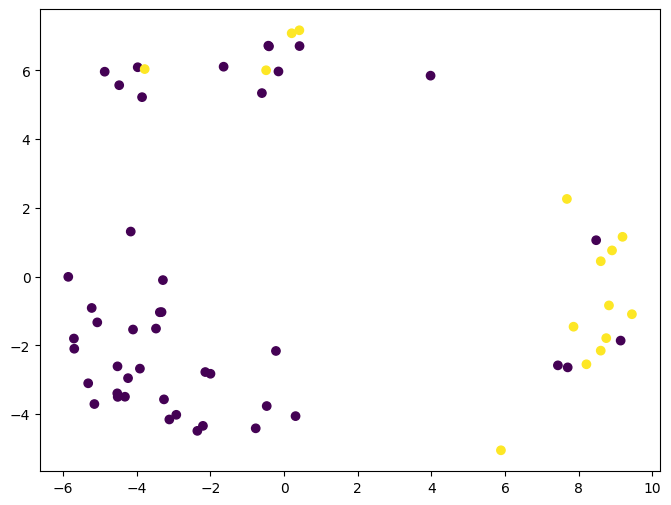

In [194]:
x_hybrid = np.empty((0,3))
x_hybrid_pca1 = x_hybrid_pca2 = y_hy2l = np.empty((0))

for features in feat_list:
    scaler_hy = StandardScaler().fit(features)
    X_train_hy = scaler_hy.transform(features)

    pca = PCA(n_components=4)
    pca.fit(X_train_hy)
    X_train_pcahy = pca.transform(X_train_hy)
    x_train_hy = X_train_pcahy[:,0:3] # Three best features
    x_hybrid = np.concatenate((x_hybrid, x_train_hy))
    x_hybrid_pca1 = np.concatenate((x_hybrid_pca1, X_train_pcahy[:,0]))
    x_hybrid_pca2 = np.concatenate((x_hybrid_pca2, X_train_pcahy[:,1]))
    y_hy2l = np.concatenate((y_hy2l, y_hy2))

plt.figure(figsize=(8,6))
plt.scatter(x_hybrid_pca1, x_hybrid_pca2, c=y_hy2l)

In [213]:
# Splitting the data in train and test data
X_train_hy, X_test_hy, y_train_hy, y_test_hy = train_test_split(x_hybrid, y_hy2l, test_size=0.2, random_state=5)
# X_train, X_test, y_train, y_test = features[0:53], features[53:], y[0:53], y[53:]
# X_train, X_test, y_train, y_test = features[0:262], features[262:], y[0:262], y[262:]
# Scaling the data

scaler_hy = StandardScaler().fit(X_train_hy)
X_train_hyy = scaler_hy.transform(X_train_hy)
X_test_hy = scaler_hy.transform(X_test_hy)

logistic_model_hy = LogisticRegression()
logistic_model_hy.fit(X_train_hy, y_train_hy)
Y_test_pred_hy = logistic_model.predict(X_test_hy)
log_score_hy = logistic_model.score(X_test_hy,y_test_hy)

svm_model_hy = svm.SVC()
svm_model_hy.fit(X_train_hy, y_train_hy)
Y_test_pred_hy = svm_model_hy.predict(X_test_hy)
svm_score_hy = svm_model_hy.score(X_test_hy,y_test_hy)


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
val_accuracies_hy = []
for i in range(5): # run 5 times with 5 random states to determine model accuracy
    # Splitting the data in train and test data
    X_trainn_hy, X_testn_hy, y_trainn_hy, y_testn_hy = train_test_split(x_hybrid, y_hy2l, test_size=0.2, random_state= i + 1)
    # Scaling the data
    scaler_hy = StandardScaler().fit(X_trainn_hy)
    X_trainn_hy = scaler.transform(X_trainn_hy)
    X_testn_hy = scaler.transform(X_testn_hy)
    ## Convert labels to categorical
    y_train_cat_hy = to_categorical(y_trainn_hy,3)
    y_test_cat_hy = to_categorical(y_testn_hy,3)
    # Define the feedforward neural network
    neural_model_hy = Sequential()
    neural_model_hy.add(Dense(128, activation='relu', input_shape=(3,)))
    neural_model_hy.add(Dense(128, activation='relu'))
    neural_model_hy.add(Dense(128, activation='relu'))
    neural_model_hy.add(Dense(128, activation = 'relu'))
    neural_model_hy.add(Dropout(0.5))
    neural_model_hy.add(Dense(3, activation='softmax'))
    # Compile the model
    optimizer = Adam(learning_rate=0.001)
    neural_model_hy.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
    # Train the model
    # history = model.fit(X_train_pca, y_train, validation_data=(X_test_pca, y_test), epochs=45, batch_size=100, verbose=2)
    history_hy = neural_model_hy.fit(X_trainn_hy, y_train_cat_hy, validation_data=(X_testn_hy, y_test_cat_hy), epochs=45, batch_size=100, verbose=0)
    val_accuracy_hy = history_hy.history['val_accuracy'][-1]
    val_accuracies_hy.append(val_accuracy_hy) # accuracy score
# print(val_accuracies)
avg_val_accuracy_hy = sum(val_accuracies_hy) / len(val_accuracies_hy) # average of accurracy scores
# print("Average Validation Accuracy:", avg_val_accuracy)
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.legend(['accuracy', 'val_accuracy'])
#from sklearn.datasets import make_classification

from sklearn.ensemble import RandomForestClassifier
# define the model
randomf_model_hy = RandomForestClassifier()
# fit/train the model on all features
randomf_model_hy.fit(X_train_hy, y_train_hy)
Y_test_pred_hy = randomf_model.predict(X_test_hy)
#score
rf_score_hy = randomf_model_hy.score(X_test_hy, y_test_hy)


In [214]:
y_test_cat_hy = to_categorical(y_test_hy)
y_test1_hy = y_test_cat_hy.astype('int64')
testYarg = np.argmax(y_test1, axis = 1)
def model_predict_neural(X_test, y_test1, model):
    predictions = model.predict(X_test)
    predictions = np.argmax(predictions, axis = 1)
    y_test1 = y_test1.astype('int64')
    testYarg = np.argmax(y_test1, axis = 1)
    miss_class = np.where(predictions != testYarg)
    miss_class = miss_class[0]
    # print("Neural network")
    # print("Predicted:",predictions)
    # print("Correct:  ",testYarg)
    # print("Index missclassified:", miss_class)
    # print("Score:", val_accuracy, "\n")
    return predictions, miss_class, testYarg
def model_predict(X_test, y_test1, model):
    predictions = model.predict(X_test)
    #y_test1 = y_test1.astype('int64')
    #testYarg = np.argmax(y_test1, axis = 1)
    miss_class = np.where(predictions != y_test1)
    miss_class = miss_class[0]
    score=model.score(X_test, y_test1)
    # print(model)
    # print("Predicted:",predictions)
    # print("Correct:  ",testYarg)
    # print("Index missclassified:", miss_class)
    # print("Score:", score, "\n")
    return predictions, miss_class, testYarg
# model_predict_neural(X_test, y_test_cat, neural_model)
# model_predict(X_test, y_test, logistic_model)
# model_predict(X_test, y_test, svm_model)
# predictions = model_predict(X_test, y_test, randomf_model)

from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
def cross_validation(X, y, model, acc_d, std_d):
    cv = KFold(n_splits= 5, random_state=1, shuffle=True)
    scores = cross_val_score(model, X,y, scoring='accuracy', cv=cv, n_jobs=-1)
    # print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
    # print(str(model))
    acc_d[str(model)].append(mean(scores))
    std_d[str(model)].append(std(scores))
    return scores
print("Logistic regression")
cv_logistic = cross_validation(x_hybrid, y_hy2l, logistic_model_hy, acc_d, std_d)
print(cv_logistic,"\n\nSVM")
cv_svm = cross_validation(x_hybrid, y_hy2l, svm_model_hy, acc_d, std_d)
print(cv_svm, "\n\nRandomforest")
cv_randomf = cross_validation(x_hybrid, y_hy2l, randomf_model_hy, acc_d, std_d)
print(cv_randomf, "\n\nNeural Network")
# print("Accuracy:", avg_val_accuracy)
print(val_accuracies)
#print ('ACC std:', '{0:0.3f}'.format(np.std(val_accuracies)), "\n")
#nnmean.append(avg_val_accuracy)
#nnstd.append(np.std(val_accuracies))

Logistic regression
[0.83333333 0.83333333 0.83333333 0.83333333 0.91666667] 

SVM
[0.83333333 0.91666667 0.83333333 0.83333333 0.91666667] 

Randomforest
[0.91666667 0.83333333 0.75       0.91666667 0.75      ] 

Neural Network
[0.8333333134651184, 0.8333333134651184, 0.8333333134651184, 0.9166666865348816, 0.75]
